In [321]:
import pandas as pd
import re
import matplotlib.pyplot as plt  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from IPython.display import display
from sklearn.metrics import f1_score
import joblib
from pathlib import Path
from sklearn.metrics import confusion_matrix

In [322]:
def get_review_df():
  stemmer = PorterStemmer()
  corpus = []
  with open('../Task_6/data/hygiene.dat', 'r') as f:
    for line in f:
      line = re.sub(r'[^A-Za-z\s]', '', line)
      corpus.append(line)
  stemmed_corpus = [stemmer.stem(word) for word in corpus]

  df = pd.DataFrame({'Stemmed_Reviews': stemmed_corpus})
  return df

In [323]:
def get_y():
  labels = []
  with open('../Task_6/data/hygiene.dat.labels.txt', 'r') as f:
    for line in f:
      line = list(line)
      for ch in line:
        if ch == '0' or ch == '1':
          labels.append(int(ch))
  f.close()
  return labels

In [324]:
## Getting data and labels

df_reviews = get_review_df()
df_additional = pd.read_csv('../Task_6/data/hygiene.dat.additional', 
  sep=",", 
  usecols=[0,1,2,3], 
  names=['Categories', 'Zip_Code', 'Num_Reviews', 'Rating'],
  dtype={'Categories': str, 'Zip_Code': str, 'Num_Reviews': str, 'Rating': float}
  )
df_additional['Rating'] = df_additional['Rating'].round().astype(int)
df = df_additional.join(df_reviews)

labels = get_y()
X_train, X_test, y_train, y_test = train_test_split(df, labels, train_size=0.04098052, shuffle=False)

In [325]:
# Taken from https://stackoverflow.com/questions/51695322/compare-multiple-algorithms-with-sklearn-pipeline
class ClfSwitcher(BaseEstimator):
  def __init__(self, estimator = SGDClassifier()):
    self.estimator = estimator
  
  def fit(self, X, y=None, **kwargs):
    self.estimator.fit(X,y)
    return self
  
  def predict(self, X, y=None):
    return self.estimator.predict(X)
    
  def predict_proba(self, X):
    return self.estimator.predict_proba(X)

  def score(self, X, y):
    return self.estimator.score(X, y)

In [326]:
gscv_file = Path('./results/gscv_object.pkl')
results_file = Path('./results/gscv_results.pkl')
predictions_file = Path('./results/predict.pkl')

if gscv_file.exists() and results_file.exists() and predictions_file.exists():
  gscv = joblib.load('./results/gscv_object.pkl')
  results = joblib.load('./results/gscv_results.pkl')
  y_true, y_pred = joblib.load('./results/predict.pkl')
else:
  pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
      [
        ('cv1', CountVectorizer(), 'Categories'),
        ('cv2', CountVectorizer(), 'Zip_Code'),
        ('cv3', CountVectorizer(), 'Num_Reviews'),
        ('onehot', OneHotEncoder(dtype='int', categories='auto', sparse=False), ['Rating']),
        ('tfidf', TfidfVectorizer(strip_accents='unicode', max_features=100000, stop_words='english'), 'Stemmed_Reviews')
      ],
      remainder= 'passthrough')
    ),
    ('clf', ClfSwitcher())
  ])

  parameters = [
    {
      'clf__estimator': [SGDClassifier()], 
      'preprocessor__tfidf__max_df': (0.5, 0.75, 0.9),
      'preprocessor__tfidf__min_df': (1,10,20),
      'preprocessor__tfidf__ngram_range': [(1,1),(1,2)],
      'clf__estimator__loss': ['hinge', 'log', 'modified_huber'] # SVM = hinge loss, LogReg = log loss, LC with modified huber loss (more tolerance to outliers)   
    },
    {
      'clf__estimator': [MultinomialNB(alpha=0.1)],
      'preprocessor__tfidf__max_df': (0.5, 0.75, 0.9),
      'preprocessor__tfidf__min_df': (1,10,20),
      'preprocessor__tfidf__ngram_range': [(1,1),(1,2),(2,2)]
    }
  ]
  gscv = GridSearchCV(pipeline, parameters, cv=5, verbose=1, scoring='f1_macro')
  joblib.dump(gscv, './results/gscv_object.pkl')
  gscv.fit(X_train, y_train)
  results = gscv.cv_results_
  joblib.dump(results, './results/gscv_results.pkl')
  y_true, y_pred = y_test, gscv.predict(X_test)
  joblib.dump([y_true, y_pred], './results/predict.pkl')


In [327]:
pd.options.display.max_rows = 100

results_df = pd.DataFrame({
  'Rank': results['rank_test_score'], 
  'Mean Fit Time': results['mean_fit_time'],
  'Mean F1 Score': results['mean_test_score'], 
  'Model': results['param_clf__estimator'],
  'Loss (LC only)': results['param_clf__estimator__loss'],
  'TF-IDF: Max DF': results['param_preprocessor__tfidf__max_df'],
  'TF-IDF: Min DF': results['param_preprocessor__tfidf__min_df'],
  'N-Grams': results['param_preprocessor__tfidf__ngram_range'],
  }).sort_values(by=['Rank'])

display(results_df.head(50))

,Rank,Mean Fit Time,Mean F1 Score,Model,Loss (LC only),TF-IDF: Max DF,TF-IDF: Min DF,N-Grams
72,1,0.223976,0.642892,MultinomialNB(alpha=0.1),NaN,0.9,1,"(1, 1)"
54,2,0.226225,0.642827,MultinomialNB(alpha=0.1),NaN,0.5,1,"(1, 1)"
63,3,0.224918,0.640775,MultinomialNB(alpha=0.1),NaN,0.75,1,"(1, 1)"
58,4,0.766590,0.629200,MultinomialNB(alpha=0.1),NaN,0.5,10,"(1, 2)"
57,5,0.222381,0.628820,MultinomialNB(alpha=0.1),NaN,0.5,10,"(1, 1)"
66,6,0.221729,0.624851,MultinomialNB(alpha=0.1),NaN,0.75,10,"(1, 1)"
78,7,0.217446,0.624553,MultinomialNB(alpha=0.1),NaN,0.9,20,"(1, 1)"
61,8,0.768169,0.624293,MultinomialNB(alpha=0.1),NaN,0.5,20,"(1, 2)"
69,9,0.219391,0.624280,MultinomialNB(alpha=0.1),NaN,0.75,20,"(1, 1)"
60,9,0.219462,0.624280,MultinomialNB(alpha=0.1),NaN,0.5,20,"(1, 1)"


Best F1 Score: 0.8094744117461505


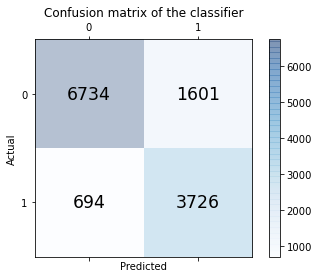

In [328]:
print(f"Best F1 Score with Rank 1 Model: {f1_score(y_true, y_pred, average='macro')}")

labels = ['Pass', 'Fail']
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()